#Overview:

The focus of this project is to predict the review scores on goodreads from just review text written by users. This kind of text classification (into 5 classes of scores) has been done through deep neural networks. These results, both show the significance of using a neural network for this problem, as well as the need to move toward more computationally complex and deep networks. 

We started with some descriptory analysis, to see general trends within our training data. Then, we built a basic machine learning text classification model using logistical regression. Having that as our ML baseline, we built a simple 3 layer neural network, using 1 dense layer, 1 embedding layer, and one output layer. We looked for accuracy levels in both test and train datasets, and checked if our results are robust, avoiding overfitting (as these models can often get). After this, we began investigating optimal number of neurons within this basic 3 layer neural network by checking model performance for varying neurons. 

From there, we built a more complex neural network, namely with a layer of a 1-D Convolutional network. Here again, we try to look for the "ideal" activation function in the output layer, though our research suggested that for multi-label classifications, softmax activation functions are often the [norm](https://machinelearningmastery.com/softmax-activation-function-with-python/). 

Lastly, we tried some deep neural networks such as LSTM to better our performance. Our initial observations were that these models were time and memory consuming, and allowed for less manipulation given our limited capacity of system availability. Further, we found these models to add very little to the overall accuracy over our test dataset. This perhaps points toward more preprocessing in our input data.

#Method:

1. Data exploration : Our initial finding was that the ratings are skewed in favour of high ratings (more than 3). However, the number of words used per review seem to be similar across all ratings. This helps us introduce Bag-of-words tokenisation methods to vectorize our text data into numeric form. 

2. Text pre-processing : As such there doesn't seem to be large outliers in the rating data column which need to be dealt with. As for the text data, as mentioned before, we used tokenization methods. For the ML baseline model we used the "CountVectorizer" to transform the data into numeric vectors. However, for all subsequent neural networks we used "Tokenizer" function from keras and then converted our tokens into sequences with a built in "text_to_sequence" function. 

  In the former method, the tokenization method converts all sentences into token vectors, and then takes them as features into the model. However, since we are dealing with review text, most often they do not have a lower or upper bound in terms of words, the number of features in this case for each input would differ. This can also bring potential bias into the model. To counter this, we have used the "Tokenizer", "text_to_sequence" and "pad_sequence" functions from keras. 

3. Train/Test Validation Strategy: Following general practice, for the ML baseline model we split all our labelled data (training dataset) into 80% training and 20% testing dataset. At this point, since we are using a baseline ML model, with no recourse for optimizing our accuracy levels, we didn't consider a validation dataset. 

  For all the neural networks models subsequently, we first split our labelled data in 80% training and 20% testing data. Of the training dataset thus obtained, we split it further into 75% actual training data, and 25% validation data. Here, the validation data is important to consider, as we will use it to validate our accuracy and loss results through each epoch, and our model wil try to optimize. 

In [3]:
#Importing packages 
import numpy as np 
import pandas as pd 
from pandas import Series, DataFrame
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_hub as hub 
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from keras.optimizers import SGD
from sklearn.metrics import roc_auc_score
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten, Conv2D
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import layers 
from keras import Sequential
from sklearn.multioutput import MultiOutputClassifier
import math
from sklearn.metrics import classification_report

In [4]:
#Mounting drive so I can retrieve my csv files from the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Reading the training data csv file into a pandas dataframe
reads = pd.read_csv("drive/My Drive/Colab Notebooks/my_goodreads_train.csv")

In [6]:
#Checking the first 5 values in the dataframe
reads.head(5)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,1da3dcc13cf360b9ecb06251e86237535,182091851,1c949b5dedf860514ec8b97ad158c9f4f,5,I thought this was a very good historical fant...,Fri Feb 01 16:44:16 -0800 2013,Tue Oct 25 18:49:25 -0700 2016,Sat May 04 00:00:00 -0700 2013,Thu Apr 25 00:00:00 -0700 2013,5,6
1,1ae436441b6153473ef907aed1006a159,1451461,112ee86a20d7e4308c0a054f8b03128cd,5,I've had this book recommended to me more than...,Sun Nov 08 12:10:16 -0800 2015,Sun Nov 08 12:24:59 -0800 2015,Tue May 05 00:00:00 -0700 2015,Sun May 03 00:00:00 -0700 2015,0,0
2,1aa5e9d859b0c0737f4b99a07edf19c88,13483572,1253729b67f301b75a0f26e85f6d6fb31,5,Seriously! You go and throw that twist into th...,Wed Oct 10 02:07:19 -0700 2012,Sat Apr 27 00:40:19 -0700 2013,Sat Apr 27 00:40:19 -0700 2013,Thu Apr 25 00:00:00 -0700 2013,0,0
3,1940c22aba67c3d49ccd37891c52c9f51,131585171,1ae0005e94dce0dc5c18d6ae2b4a329ab,4,Gosh!!! I'm still not recovering from the effi...,Thu Dec 05 00:45:29 -0800 2013,Thu Dec 05 00:50:17 -0800 2013,Thu Dec 05 00:50:17 -0800 2013,Wed Dec 04 00:00:00 -0800 2013,5,0
4,15e03534fccd0e7e1849d712ab9e44342,195643271,1d8357d2abdcc656635c5459c1feec761,3,"3.5 stars rounded down. I can't help it, I jus...",Wed Mar 15 18:08:14 -0700 2017,Wed Jul 05 12:55:32 -0700 2017,Wed Apr 12 12:17:07 -0700 2017,Tue Apr 11 00:00:00 -0700 2017,0,0


In [7]:
#Carrying forward only two columns, review text (independant variable) and rating (dependant variable)
reads_use=reads[['review_text', "rating"]]
reads_use.shape

(700000, 2)

array([[<Axes: title={'center': 'rating'}>]], dtype=object)

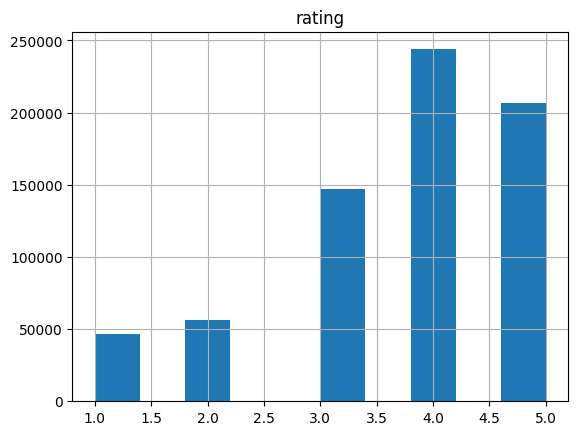

In [8]:
#Distribution of ratings across the dataset 
reads_use.hist(['rating'])

In [8]:
#Counting the number of words used in each text review
reads_use['word_count'] = reads_use['review_text'].apply(lambda x: len(str(x).split()))

<ipython-input-8-edddd688d6d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reads_use['word_count'] = reads_use['review_text'].apply(lambda x: len(str(x).split()))


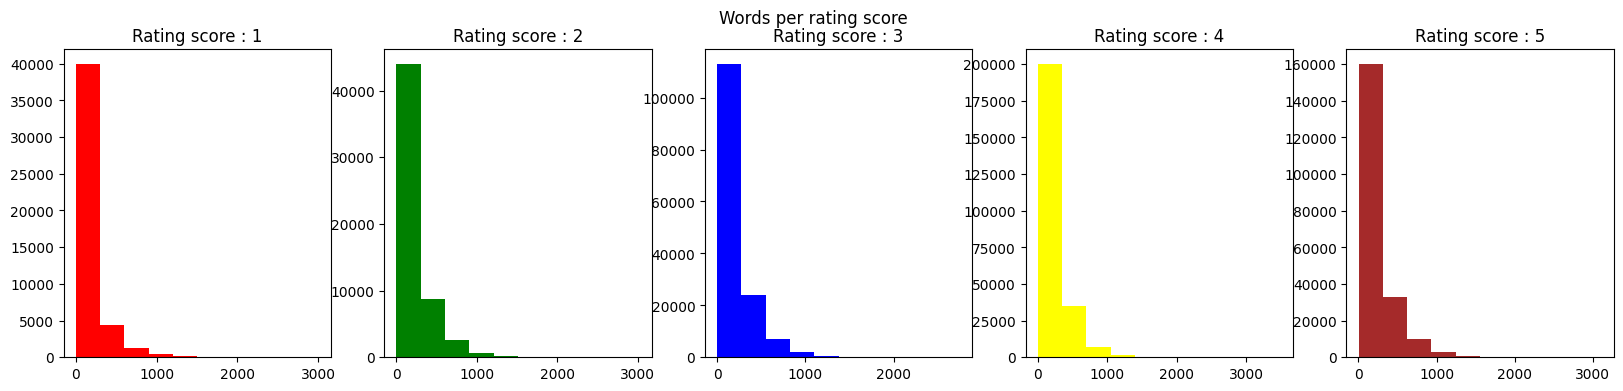

In [9]:
#Plotting the number of words in a text review per rating score
fig,(ax1,ax2, ax3, ax4, ax5)=plt.subplots(1,5,figsize=(20,4))
rating1=reads_use[reads_use['rating']==1]['word_count']
ax1.hist(rating1,color='red')
ax1.set_title('Rating score : 1')
raiting2=reads_use[reads_use['rating']==2]['word_count']
ax2.hist(raiting2,color='green')
ax2.set_title('Rating score : 2')
raiting3=reads_use[reads_use['rating']==3]['word_count']
ax3.hist(raiting3,color='blue')
ax3.set_title('Rating score : 3')
raiting4=reads_use[reads_use['rating']==4]['word_count']
ax4.hist(raiting4,color='yellow')
ax4.set_title('Rating score : 4')
raiting5=reads_use[reads_use['rating']==5]['word_count']
ax5.hist(raiting5,color='brown')
ax5.set_title('Rating score : 5')
fig.suptitle('Words per rating score')
plt.show()


From the graph above, it is clear that the average number of words per rating score is uniform throughout different rating scores. This justifies a Bag-of-words tokenization method to classify text that accounts for the frequency of words, making sure there is no obvious bias in our classification.

In [9]:
#Dividing our dataset into input and output data
y = reads_use['rating']
x=reads_use['review_text']

#Baseline ML classification model using text vectorization

We start with a Baseline ML logistical regression model for classifying our review text into 5 labels. For this we have used a multinomial classification model, with 2000 iterations (as lower iterations were not sufficient enough to run the model fully). The accuracy obtained seems to be about 51%, which us pretty high, perhaps owing to possible overfitting in the model. This is because we considered all the tokens (words) in our input, even stopwords, redundant words, and perhaps those that are rare or mispelled. It is likely with untested text reviews, this model won't be able to generalize well. 

**Data preprocessing** 

As a baseline ML model we have used a Bag-of-words model to tokenize reviews, and thus accounted for the multiplicity of words, discounting for grammer and sentence cosntruction, or even individual review biases (perhaps there are reviews with that are much longer than others). Then we have inputted this tokenized feature into a simple logistical multinomial regression classifier. Here, we have used vectorization as a method. 

Vectorization is a method to convert text into numeric vectors, thus increasing the processing speed of the neural network, and help the model optimize faster. Here, we have used a simple CountVectorizer vectorization method, which makes tokens out of each word, and creates a vocabulary of unique words. Then, it creates a sparse matrix which accounts for the frequency of the word in dataset, where each column is a unique word.


In [11]:
#Calling on the function
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(x)

CountVectorizer(lowercase=False, min_df=0)

Here, we split train and test data in a 4:1 ratio (that is, 80% and 20% respectively)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1000)

In [13]:
#Tokenizing train and test data by creating a vocabulary of all words in the data
x_train = vectorizer.transform(x_train)
x_test  = vectorizer.transform(x_test)

In [14]:
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)
classifier.fit(x_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000, multi_class='multinomial')

In [16]:
#Accuracy score 
accuracy_score = classifier.score(x_test, y_test)
accuracy_score


0.5130142857142858

In [17]:
#Predicted values 
y_pred = classifier.predict(x_test)

# Baseline 3-layer neural network

We started off by tokenizing our text reviews. This is elaborated more in the following lines. 

Then we built as basic 3 layer NN model, with the first layer being an embedding layer. This layer maps our high dimensional input layers into low dimensional input layers, so we can learn better the relationship between our input data. Here, we have specified our embedding output dimension to be 50. Then we added a dense layer, with a relu activation function, taking an arbitrary 32 number of neurons. And finally, we have an output layer, that gives out 6 outputs (5 classes + bias). 

In model compilation, we have used SGD optimizer to be our loss function, which will take a curved loss function and use gradient descent to find a global minima. One of the reasons that we have taken SGD optimizer is since it gives faster processing speed than Adam optimizer, because it takes a smaller sample of the total data, and also does better than Adam in generalizing (Keskar & Socher, 2017). Further, we have taken a learning rate higher than the default, to enable learning process to be quicker. We believe this slight increase in the learning rate is pretty standard (Bengio, 2012) and won't make much difference in the robustness of our results.

Lastly, we explored models with varying neurons by creating a loop function. Through this exercise we established the optimal number of neurons to be 64. 

In [10]:
#Re-specifying our y and x variables from our master dataset
y = reads_use['rating']
x=reads_use['review_text']

We begin by splitting our data to train and test in a 8:2 ratio. The test data thus obtained is further split into training and validation data in a 3:1 ratio. 

In [11]:
x_train1, x_test1, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train1, x_val1, y_train, y_val = train_test_split(x_train1, y_train, test_size=0.25, random_state=42) # Here validation data is 0.25 x 0.8 = 0.2 of the total data

**Tokenisation and text to sequencing**

Here, we have used tokenizer to make tokens out of each word so we can construct an entire vocabulary of tokens. Here we have specified the maximum number of words in the vocabulary to considered as 5000, to make processing faster. This is the top 5000 words with the most frequency in the data. Ofcourse, a larger vocabbulary might add to the accuracy of our model, however it would be an additional burden on our model to run. Further, a large vocabulary may lead to overfitting, where more trivial words start being fit into the model. 

Further, the "texts_to_sequences" function from keras helps convert text rows into a series of token sequences. This step helps make sense of the data in terms of indexing it as a sequence, rather than words being considered as disparate tokens.

In [12]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x)
x_train = tokenizer.texts_to_sequences(x_train1)
x_test = tokenizer.texts_to_sequences(x_test1)
x_val = tokenizer.texts_to_sequences(x_val1)
vocab_size = len(tokenizer.word_index) + 1  # Since there is an index 0, adding 1 

#Checking if the tokenization is done correctly in the right format 
print(x_train1[5])
print(x_train[5])

When I first read The Wasp Factory for a Scottish literature class about five years ago, I was fascinated by the story and the perverse complexity of Frank's character. The book was unlike anything I'd ever read before, so bizarre and macabre that I didn't even know how to process it. 
 But when I just reread it, I found the whole thing rather hokey. None of the intrigue remained from my first go-through, and vaguely remembering the ending, I found the book somewhat desperate, trying to put all the miscellaneous pieces together in some haphazard way to make the book's ending actually work. And maybe it was because I'd already read it and knew how it was all going to end, but I was rolling m eyes at some of the obvious attempts author Iain Banks made to somehow connect the important events in Frank's life. 
 So the story is about a sixteen-year-old kid, the aforementioned Frank, and his extremely tense relationship with his father and brother. Frank is obsessed with shamanistic rituals,

**Padding sequences** 

Here, we specify the maximum length of a sequence of words to keep. Now, the list of sequences may most likely be of different sizes, owing to different review text sizes. And so it is important to make them uniform, in order to reduce bias, and increase computational power of our model. Hence, we specify the maximum length of a review to be 200 tokens (words). Tokens more than that will be truncated.

In [13]:
maxlen = 200
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)
x_val = pad_sequences(x_val, padding='post', maxlen=maxlen)

print(x_train[0, :])

[   2  962    4  291   33  172 1267   20 3275    2 1342   16 1775    4
 2889  604    2 4001   67 1808 1048   12    9   33  124  111    1 4877
   24    1    2   38  231    1 1511    6  212   53   38   66   18   82
 2537   26  224    1  828   10    9   21   38 1477    2  299  480   38
  202  225   49   18    5 4524 1705   89    3  186  138  357    1    8
   84   18    5   14   45  618   37 1262  163    2   56   22  345 4960
 2821   33    9    6 1407 4008   19  368   12    9   21  828  442   14
  143   37   29  113   15    1  396    4  136  528  373   12   13    9
   15   69  307  110    7  105   25   30   18  765   18 2654 1547    2
   67  112    3   63   26  100  158    7   10  327  300    2   30    7
   18   49  489   62   21  109    4  153  636   15    1  828   21  111
  860  708   48   18    7   63   25   10   49  489   53   67  354  134
  252   15  216 2004 1711   12    9  338    1  126  752 2824    6 1409
 1995 1517 1050 1518 1914   18    5 3148    2   19  140   39 4936 2428
    3 

In [37]:
#Initial 3-NN model

from keras.models import Sequential
from keras import layers

embedding_dim = 50

model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model1.add(layers.Flatten())
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dense(6, activation='softmax'))

In [38]:
optz= SGD(learning_rate=0.01) 
model1.compile(optimizer=optz,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 50)           15714600  
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 16)                160016    
                                                                 
 dense_3 (Dense)             (None, 6)                 102       
                                                                 
Total params: 15,874,718
Trainable params: 15,874,718
Non-trainable params: 0
_________________________________________________________________


In [39]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01)

Here, early stopping is used as a callback from our epochs if the accuracy doesn't increase by atleast 1%. 

In [40]:
history1 = model1.fit(x_train, y_train, epochs=8, validation_data=(x_val, y_val), batch_size=50, callbacks=[early_stopping])
#accuracy : .50 approx

Epoch 1/8
8400/8400 [==============================] - 55s 7ms/step - loss: 1.4415 - accuracy: 0.3494 - val_loss: 1.4224 - val_accuracy: 0.3537
Epoch 2/8
8400/8400 [==============================] - 54s 6ms/step - loss: 1.3625 - accuracy: 0.3966 - val_loss: 1.3108 - val_accuracy: 0.4341
Epoch 3/8
8400/8400 [==============================] - 53s 6ms/step - loss: 1.2818 - accuracy: 0.4410 - val_loss: 1.2784 - val_accuracy: 0.4415
Epoch 4/8
8400/8400 [==============================] - 54s 6ms/step - loss: 1.2230 - accuracy: 0.4654 - val_loss: 1.1956 - val_accuracy: 0.4793
Epoch 5/8
8400/8400 [==============================] - 53s 6ms/step - loss: 1.1743 - accuracy: 0.4867 - val_loss: 1.1552 - val_accuracy: 0.4954
Epoch 6/8
8400/8400 [==============================] - 53s 6ms/step - loss: 1.1390 - accuracy: 0.5035 - val_loss: 1.1372 - val_accuracy: 0.5003
Epoch 7/8
8400/8400 [==============================] - 53s 6ms/step - loss: 1.1135 - accuracy: 0.5156 - val_loss: 1.1320 - val_accuracy:

In [41]:
history1.history

{'loss': [1.4414719343185425,
  1.3624937534332275,
  1.2817879915237427,
  1.2230463027954102,
  1.174343228340149,
  1.1390204429626465,
  1.1134768724441528],
 'accuracy': [0.3494476079940796,
  0.39664047956466675,
  0.4409928619861603,
  0.46540239453315735,
  0.48665714263916016,
  0.5034809708595276,
  0.5155524015426636],
 'val_loss': [1.4223800897598267,
  1.3107892274856567,
  1.2784305810928345,
  1.1956442594528198,
  1.1552457809448242,
  1.1371887922286987,
  1.1319975852966309],
 'val_accuracy': [0.35374999046325684,
  0.4340857267379761,
  0.44154998660087585,
  0.47928571701049805,
  0.4954499900341034,
  0.5003499984741211,
  0.5078428387641907]}

In [42]:
history1.history['loss'][0]

1.4414719343185425

In [58]:
#Evaluating our model accuracy on testing data (labelled)
results = model1.evaluate(x_test, y_test)

4375/4375 [==============================] - 9s 2ms/step - loss: 1.1308 - accuracy: 0.5100


In [44]:
results[0]

1.1307857036590576

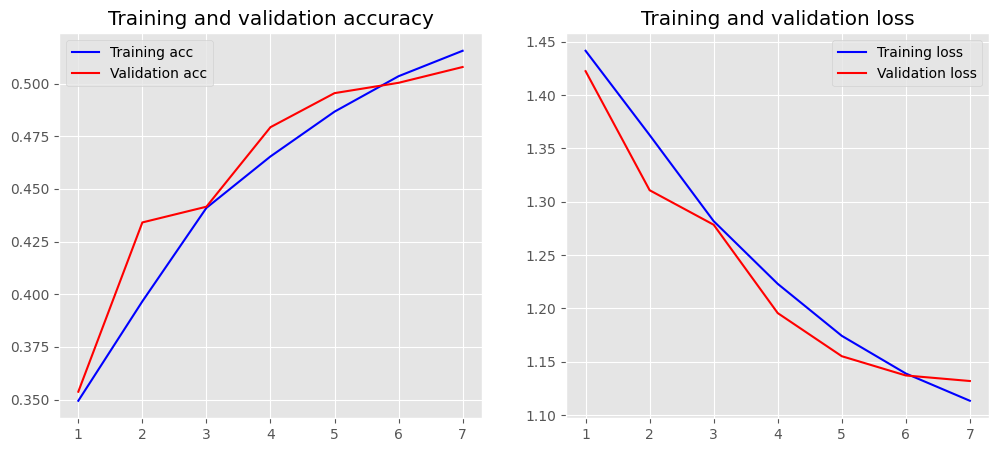

In [45]:
#Plotting accuracy and loss of the model
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history1):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history1)

In [46]:
embedding_dim = 50
nuerons_counts = [8,16,32,64,512]
test_outcomes = [] # list of accuracy scores
loss_function = [] #list of loss scores

In [47]:
for nodes in nuerons_counts:
      model_loop = Sequential()
      model_loop.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
      model_loop.add(layers.Flatten())
      model_loop.add(layers.Dense(nodes, activation='relu'))
      model_loop.add(layers.Dense(6, activation='softmax'))

      # Compile model
      model_loop.compile(optimizer=optz,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 
      model_loop.fit(x_train, y_train, epochs=6, validation_data=(x_val, y_val), batch_size=50, callbacks=[early_stopping])

      # Get accuracy from test data
      test_accuracy = model_loop.evaluate(x_test, y_test)

      # Append accuracy scores to the test outcomes list
      test_outcomes.append(test_accuracy[1])
      loss_function.append(test_accuracy[0])

Epoch 1/6
8400/8400 [==============================] - 49s 6ms/step - loss: 1.4486 - accuracy: 0.3495 - val_loss: 1.4232 - val_accuracy: 0.3545
Epoch 2/6
8400/8400 [==============================] - 48s 6ms/step - loss: 1.3735 - accuracy: 0.3984 - val_loss: 1.3184 - val_accuracy: 0.4368
Epoch 3/6
8400/8400 [==============================] - 48s 6ms/step - loss: 1.2991 - accuracy: 0.4372 - val_loss: 1.2696 - val_accuracy: 0.4487
Epoch 4/6
8400/8400 [==============================] - 49s 6ms/step - loss: 1.2563 - accuracy: 0.4545 - val_loss: 1.2331 - val_accuracy: 0.4624
Epoch 5/6
8400/8400 [==============================] - 49s 6ms/step - loss: 1.2110 - accuracy: 0.4715 - val_loss: 1.1953 - val_accuracy: 0.4802
Epoch 6/6
4375/4375 [==============================] - 8s 2ms/step - loss: 1.1783 - accuracy: 0.4845
Epoch 1/6
8400/8400 [==============================] - 54s 6ms/step - loss: 1.4441 - accuracy: 0.3489 - val_loss: 1.4222 - val_accuracy: 0.3489
Epoch 2/6
8400/8400 [==============

In [48]:
loss_function

[1.1783277988433838,
 1.1796882152557373,
 1.1419938802719116,
 1.1285154819488525,
 1.1151587963104248]

In [50]:
test_outcomes

[0.48453572392463684,
 0.4834071397781372,
 0.5009499788284302,
 0.5072357058525085,
 0.5130357146263123]

In [51]:
nuerons_counts

[8, 16, 32, 64, 512]

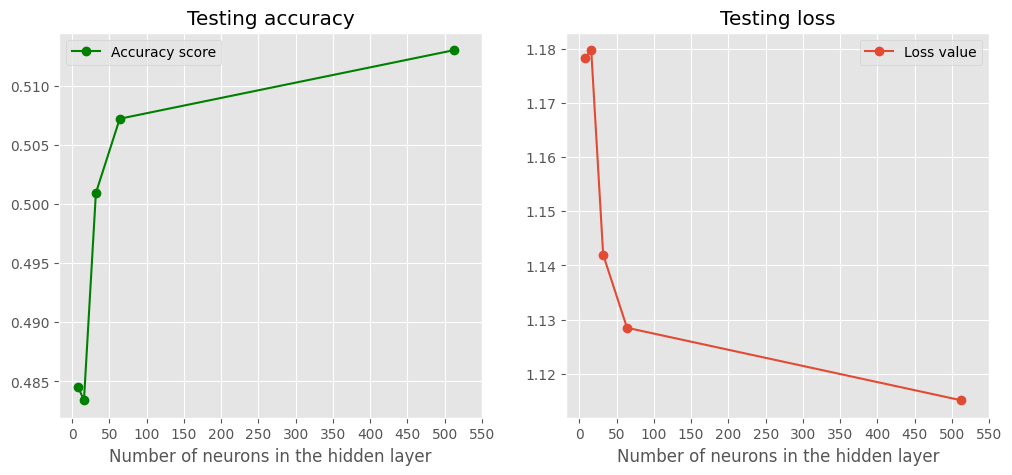

In [52]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(nuerons_counts, test_outcomes, label='Accuracy score', marker='o', color='g')
plt.xticks([0,50,100,150,200,250,300,350,400,450,500,550])
plt.title('Testing accuracy')
plt.legend()
plt.xlabel("Number of neurons in the hidden layer")
plt.subplot(1, 2, 2)
plt.plot(nuerons_counts, loss_function, label='Loss value', marker='o')
plt.xticks([0,50,100,150,200,250,300,350,400,450,500,550])
plt.xlabel("Number of neurons in the hidden layer")
plt.title('Testing loss')
plt.legend()

**Ideal number of neurons**

We can see that as we increased the number of neurons in our hidden layer, loss reduced and accuracy increased in both validation and training sets increased. Although it makes sense sense to go with the number of neurons that gives the best accuracy and lowest loss value, which in this case is 512 neurons, we believe this is not entirely ideal. To begin with, we could possibly have more accuracy with even more neurons (greater than 512), and thus this number seems a bit arbitrarily picked. Also, if we activate these many neurons after our embedding layer, without a dropout layer, it may lead to some overfitting. This is a bit evident from the above graph, where increasing the neurons from 64 to 512 (which is a massive leap) is increasing the accuracy only by about 1% approx. This marginal increase, added with the additional computational time that will be taken for computing 448 more neurons makes it a less than ideal option. Hence, for our final model, we have decided to go with 64 neurons. 



In [68]:
#Final 3-NN model 
modelfinal = Sequential()
modelfinal.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
modelfinal.add(layers.Flatten())
modelfinal.add(layers.Dense(64, activation='relu'))
modelfinal.add(layers.Dense(6, activation='softmax'))

optz= SGD(learning_rate=0.01)
modelfinal.compile(optimizer=optz,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
modelfinal.summary()
history_final = modelfinal.fit(x_train, y_train, epochs=8, validation_data=(x_val, y_val), batch_size=50, callbacks=[early_stopping])

Exception ignored in: <function _xla_gc_callback at 0x7fa4ae1a6ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 50)           15714600  
                                                                 
 flatten_10 (Flatten)        (None, 10000)             0         
                                                                 
 dense_20 (Dense)            (None, 64)                640064    
                                                                 
 dense_21 (Dense)            (None, 6)                 390       
                                                                 
Total params: 16,355,054
Trainable params: 16,355,054
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
8400/8400 [==============================] - 89s 11ms/step - loss: 1.4384 - accuracy: 0.3534 - val_loss: 1.4119 - val_accuracy: 0.3675
Epoch 2/8
8400/8400 [=======

## Predicting our basic 3-NN on real testing data

In [13]:
reads_test = pd.read_csv("drive/My Drive/Colab Notebooks/my_goodreads_test.csv")

In [70]:
reads_test.head(2)

,Unnamed: 0,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,2212,11f7623a30dd3f47258dd9a4c806f6850,10439467,16c32b9bb0142734c60f8b028f281c5dd,"3-3.5 stars \n While I liked it, I didn't love...",Wed Oct 17 11:33:43 -0700 2012,Fri Feb 24 20:18:32 -0800 2017,Fri Feb 12 06:19:31 -0800 2016,Sat Feb 06 00:00:00 -0800 2016,1,0
1,655187,1b700c4dfcecf272a3d18fea04d1a7f3a,129377,1f86ec340856f1097c922d33aed48d4ea,"First, I must fangirl over the ending. *OMG FA...",Mon Mar 02 14:15:20 -0800 2015,Thu Jul 21 11:27:01 -0700 2016,Wed Apr 29 00:00:00 -0700 2015,Mon Apr 27 00:00:00 -0700 2015,0,0


In [71]:
reads_test1 = reads_test

In [72]:
x_test=reads_test1['review_text']

In [73]:
# Tokenization of the real testing data
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [74]:
#Fitting our testing inputs into our model
nn1_predictions = modelfinal.predict(x_test)
nn1_predictions= np.argmax(nn1_predictions, axis=1)

6250/6250 [==============================] - 15s 2ms/step


In [75]:
#Size of the predictions array
nn1_predictions.shape

(200000,)

In [76]:
#Converting predictions array to a list
reads_test1['rating']=nn1_predictions.tolist()

In [77]:
#Reducing the testing dataframe into two columns
reads_test1 = reads_test1[['review_id', 'rating']]

In [78]:
reads_test1.head(2)

,review_id,rating
0,16c32b9bb0142734c60f8b028f281c5dd,3
1,1f86ec340856f1097c922d33aed48d4ea,4


In [79]:
#Saving the predicted values as a dataframe in csv format
reads_test1.to_csv('drive/My Drive/Colab Notebooks/results_nn1.csv', index=False)

# Deep Neural Networks 

# CNN models

Now, we used deeper models. This is by introducong convolutional neural networks, and introducing more layers, such as dropout layers into our model. 
CNNs work by taking inputs as "filter kernels". We have considered a Conv1D layer here. Another layer for embedding we have used is the GlobalMaxPooling1D, to reduce the size of the incoming layer of inputs into our hidden layers. 

Dropout layers are also introduced, which essentially choose a proportion of random neurons that it stops from being activated in each epoch of running the model. This helps in the network learning multiple independant internal representations of data, rather than relying on set, predetermined inputs. 

**#Basic CNN model**


In [104]:
embedding_dim = 50

modelcnn = Sequential()
modelcnn.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
modelcnn.add(layers.Conv1D(128, 5, activation='relu'))
modelcnn.add(layers.GlobalMaxPooling1D())
modelcnn.add(layers.Dense(64, activation='relu'))
modelcnn.add(layers.Dense(6, activation='softmax'))

optz= SGD(learning_rate=0.01)
modelcnn.compile(optimizer=optz,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
modelcnn.summary()
history_cnn = modelcnn.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=50, callbacks=[early_stopping])


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 200, 50)           15714600  
                                                                 
 conv1d_5 (Conv1D)           (None, 196, 128)          32128     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 6)                 390       
                                                                 
Total params: 15,755,374
Trainable params: 15,755,374
Non-trainable params: 0
_________________________________________

In [ ]:
y_pred = modelcnn.predict(x_test)

**Making predictions on our actual testing data**


In [105]:
reads_test2 = reads_test
x_test=reads_test2['review_text']

In [106]:
# Tokenization of the real testing data
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [112]:
#Making predictions on our actual testing data
cnn_predictions = modelcnn.predict(x_test)
cnn_predictions= np.argmax(cnn_predictions, axis=1)

6250/6250 [==============================] - 52s 8ms/step


In [113]:
cnn_predictions.shape

(200000,)

In [114]:
reads_test2['rating']=cnn_predictions.tolist()

<ipython-input-114-f6b3f6d923aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reads_test2['rating']=cnn_predictions.tolist()


In [115]:
reads_test2 = reads_test2[['review_id', 'rating']]
reads_test2.head(2)

,review_id,rating
0,16c32b9bb0142734c60f8b028f281c5dd,3
1,1f86ec340856f1097c922d33aed48d4ea,5


In [117]:
reads_test2.to_csv('drive/My Drive/Colab Notebooks/results_cnn.csv', index=False)

This basic CNN model gives an accuracy of 55% on the validation data. 

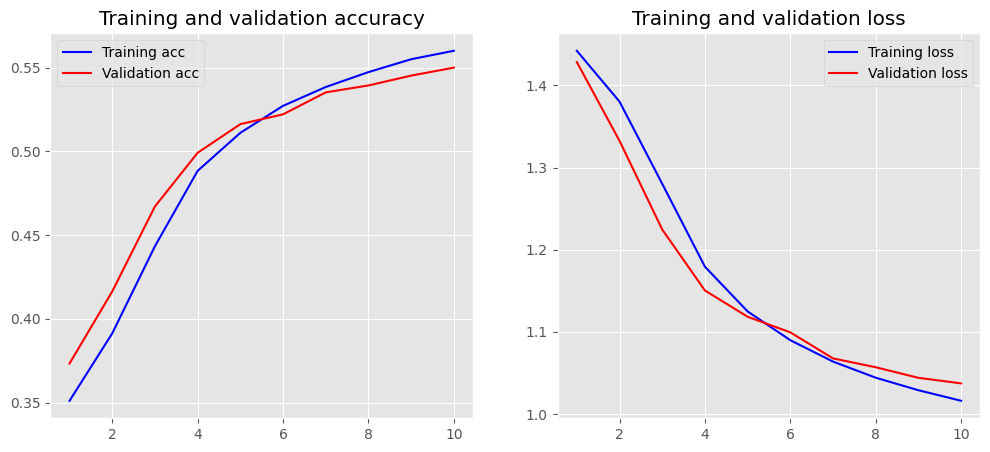

In [118]:
#Plotting accuracy and loss of the model
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history_cnn):
    acc = history_cnn.history['accuracy']
    val_acc = history_cnn.history['val_accuracy']
    loss = history_cnn.history['loss']
    val_loss = history_cnn.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history_cnn)

**#Basic CNN model + 1 dropout layer**


In [119]:
#Basic CNN model + 1 dropout layer
embedding_dim = 50

modelcnn1 = Sequential()
modelcnn1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
modelcnn1.add(layers.Conv1D(128, 5, activation='relu'))
modelcnn1.add(layers.GlobalMaxPooling1D())
modelcnn1.add(layers.Dropout(0.3))
modelcnn1.add(layers.Dense(64, activation='relu'))
modelcnn1.add(layers.Dense(6, activation='softmax'))

optz= SGD(learning_rate=0.01)
modelcnn1.compile(optimizer=optz,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
modelcnn1.summary()
history_cnn1 = modelcnn1.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=50, callbacks=[early_stopping])


Exception ignored in: <function _xla_gc_callback at 0x7fa4ae1a6ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 200, 50)           15714600  
                                                                 
 conv1d_6 (Conv1D)           (None, 196, 128)          32128     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 6)                 390       
                                                     

The basic cnn model +1 dropout layer doesn't seem to be improving accuracy than the cnn model without any dropout layers.

In [11]:
#Basic CNN model + 2 dropout layers + 2 Dense layer
embedding_dim = 50
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01)

modelcnn2 = Sequential()
modelcnn2.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
modelcnn2.add(layers.Conv1D(128, 5, activation='relu'))
modelcnn2.add(layers.GlobalMaxPooling1D())
modelcnn2.add(layers.Dropout(0.2))
modelcnn2.add(layers.Dense(64, activation='relu'))
modelcnn2.add(layers.Dropout(0.2))
modelcnn2.add(layers.Dense(32, activation='relu'))
modelcnn2.add(layers.Dense(6, activation='softmax'))

optz= SGD(learning_rate=0.01)
modelcnn2.compile(optimizer=optz,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
modelcnn2.summary()
history_cnn2 = modelcnn2.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=50, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           15714600  
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          32128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

The basic CNN model + 2 dropout layers + 2 Dense layer seems to be performing better than the basic cnn model, with a validation accuracy of 56%. In the test set in kaggle, it gives an accuracy of 51.6%. 

In [15]:
#Predicting in CNN3 model

reads_test4 = reads_test
x_test=reads_test4['review_text']

# Tokenization of the real testing data
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

#Predicting ratings 
cnn2_predictions = modelcnn2.predict(x_test)
cnn2_predictions= np.argmax(cnn2_predictions, axis=1)
cnn2_predictions.shape

reads_test4['rating']=cnn2_predictions.tolist()
reads_test4 = reads_test4[['review_id', 'rating']]

reads_test4.to_csv('drive/My Drive/Colab Notebooks/results_cnn2.csv', index=False)

6250/6250 [==============================] - 61s 10ms/step


**Testing performance on the basis of activation functions in the output layer - sigmoid and softmax functions**

In [14]:
activation_functions = ['softmax', 'sigmoid']
test_outcomesact =[]
loss_functionact =[]

In [ ]:
#Respecifying x and y split 
x_train1, x_test1, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train1, x_val1, y_train, y_val = train_test_split(x_train1, y_train, test_size=0.25, random_state=42) # Here validation data is 0.25 x 0.8 = 0.2 of the total data

#Re-processing training and validation data before running our models
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x)
x_train = tokenizer.texts_to_sequences(x_train1)
x_test = tokenizer.texts_to_sequences(x_test1)
x_val = tokenizer.texts_to_sequences(x_val1)
vocab_size = len(tokenizer.word_index) + 1  # Since there is an index 0, adding 1 

maxlen = 200
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)
x_val = pad_sequences(x_val, padding='post', maxlen=maxlen)


In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01)

for act in activation_functions:
      #Basic CNN model + 1 dropout layer
      embedding_dim = 50

      modelact = Sequential()
      modelact.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
      modelact.add(layers.Conv1D(128, 5, activation='relu'))
      modelact.add(layers.GlobalMaxPooling1D())
      modelact.add(layers.Dropout(0.3))
      modelact.add(layers.Dense(64, activation='relu'))
      modelact.add(layers.Dense(6, activation=act))

      optz= SGD(learning_rate=0.01)
      modelact.compile(optimizer=optz,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])
      modelact.summary()
      history_modelact = modelact.fit(x_train, y_train, epochs=6, validation_data=(x_val, y_val), batch_size=50, callbacks=[early_stopping])

      # Get accuracy from test data
      test_accuracyact = modelact.evaluate(x_test, y_test)

      # Append accuracy scores to the test outcomes list
      test_outcomesact.append(test_accuracyact[1])
      loss_functionact.append(test_accuracyact[0])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 50)           15714600  
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 128)          32128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                      

<ipython-input-25-243e2b5d3bad>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


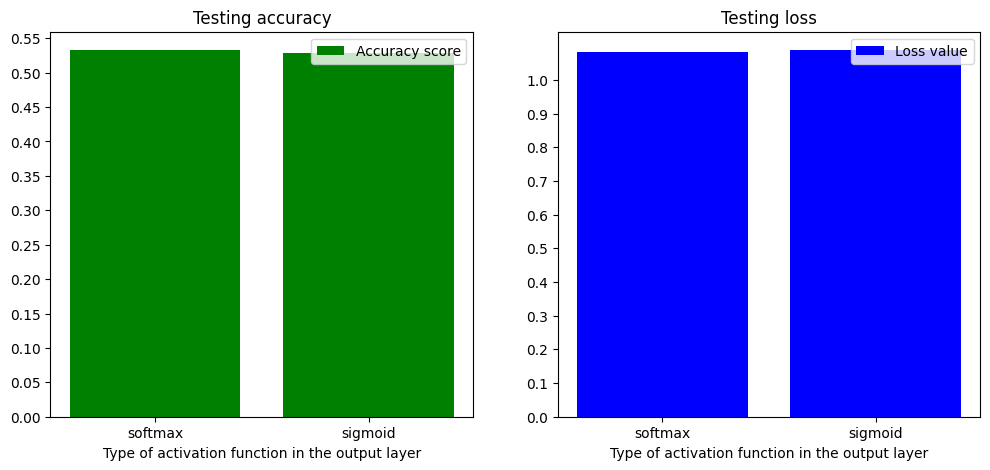

In [25]:
#Bar plot of accuracy and loss from different activation functions 
plt.figure(figsize=(12, 5))
plt.title("Performance levels of CNN models with different activation functions")
plt.subplot(1, 2, 1)
plt.bar(activation_functions, test_outcomesact, label='Accuracy score', color='g')
plt.yticks([0,0.05,0.1,0.15,0.2,.25,.30,.35,.40,.45,.50,.55])

plt.title('Testing accuracy')
plt.xlabel("Type of activation function in the output layer")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(activation_functions, loss_functionact, label='Loss value', color='b')
plt.yticks([0,0.1,0.2,.30,.40,.50,0.6,0.7,0.8,0.9,1])
plt.xlabel("Type of activation function in the output layer")
plt.title('Testing loss')
plt.legend()

We can see that both the accuracy and loss scores seem to be almost similar in the cnn model with 6 epochs run. So in terms of performance, it would appear that both activation functions are similar. However, for a multilabel classifification problem such as this, heuritics suggest that we use softmax as the predicted probabilities of each label is dependant on others. That is, for the probability of an output to be one label increasing, the predicted probability of it being all other labels should decrease. 

https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/ 

# Recurrent Neural Network

#LSTM

Lastly, for complex model, we tried LSTM. We tried BERT as well, however, it was taking a lot of processing time, and hence we could not get the results as our notebooks were crashing in runtime. 

In [123]:
#Basic LSTM model
embedding_dim = 50

modellstm = Sequential()
modellstm.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
modellstm.add(layers.Dropout(0.2))
modellstm.add(layers.LSTM(128,activation='relu'))
modellstm.add(layers.Dropout(0.2))
modellstm.add(layers.Dense(64, activation='relu'))
modellstm.add(layers.Dropout(0.2))
modellstm.add(layers.Dense(6, activation='softmax'))

optz= SGD(learning_rate=0.01)
modellstm.compile(optimizer=optz,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
modellstm.summary()
history_lstm = modellstm.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=200, callbacks=[early_stopping])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 200, 50)           15714600  
                                                                 
 dropout_3 (Dropout)         (None, 200, 50)           0         
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 6)               

The basic LSTM model seems to be performing quite bad in terms of accuracy, as compared to our more deeper models. However, this might be because we havent used appropriate layers, and neurons, and other hyperparameters. We tried to do more exploration around this, however for want of processing speed, we were not able to perform much. Our systems were crashing. With better processing speeds, we believe we could have gotten a better model. 

# References

Bengio, Y. (2012). Practical recommendations for gradient-based training of deep architectures. Neural Networks: Tricks of the Trade: Second Edition, 437-478.

Keskar, N and Socher, R. (2017). Improving Generalization Performance by Switching from Adam to SGD. 